In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/data.zip

Archive:  /content/drive/MyDrive/data.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.csv               
  inflating: train.zip               


In [4]:
!unzip /content/train.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
   creating: train/55844/
  inflating: train/55844/55844.jpg   
  inflating: train/55844/55844.json  
  inflating: train/55844/55844.csv   
   creating: train/55847/
  inflating: train/55847/55847.jpg   
  inflating: train/55847/55847.csv   
  inflating: train/55847/55847.json  
   creating: train/55848/
  inflating: train/55848/55848.json  
  inflating: train/55848/55848.csv   
  inflating: train/55848/55848.jpg   
   creating: train/55858/
  inflating: train/55858/55858.json  
  inflating: train/55858/55858.jpg   
  inflating: train/55858/55858.csv   
   creating: train/55870/
  inflating: train/55870/55870.json  
  inflating: train/55870/55870.csv   
  inflating: train/55870/55870.jpg   
   creating: train/55889/
  inflating: train/55889/55889.jpg   
  inflating: train/55889/55889.csv   
  inflating: train/55889/55889.json  
   creating: train/55895/
  inflating: train/55895/55895.jpg   
  inflating: train/55895/55895.csv   
  inflating: train/558

# 사용 패키지

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import os
import json 
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score


# 데이터 살펴보기

In [6]:
sample = 10027

sample_csv = pd.read_csv(f'/content/train/{sample}/{sample}.csv')
sample_image = cv2.imread(f'/content/train/{sample}/{sample}.jpg')
sample_json = json.load(open(f'/content/train/{sample}/{sample}.json', 'r'))

In [7]:
# csv
sample_csv

,측정시각,내부 온도 1 평균,내부 온도 1 최고,내부 온도 1 최저,내부 온도 2 평균,내부 온도 2 최고,내부 온도 2 최저,내부 온도 3 평균,내부 온도 3 최고,내부 온도 3 최저,내부 온도 4 평균,내부 온도 4 최고,내부 온도 4 최저,내부 습도 1 평균,내부 습도 1 최고,내부 습도 1 최저,내부 습도 2 평균,내부 습도 2 최고,내부 습도 2 최저,내부 습도 3 평균,내부 습도 3 최고,내부 습도 3 최저,내부 습도 4 평균,내부 습도 4 최고,내부 습도 4 최저,내부 이슬점 평균,내부 이슬점 최고,내부 이슬점 최저,내부 CO2 평균,내부 CO2 최고,내부 CO2 최저,외부 풍속 평균,외부 풍속 최고,외부 풍속 최저,내부 EC 1 평균,내부 EC 1 최고,내부 EC 1 최저,내부 PH 1 평균,내부 PH 1 최고,내부 PH 1 최저,배지 중량 평균,배지 중량 최고,배지 중량 최저,양액 온도 평균,양액 온도 최고,양액 온도 최저,외부 풍향 수치,외부 풍향,외부 빗물 시간,외부 누적일사 평균,양액 급액 누적,양액 배액 누적
0,2021-11-26 09:30:00,9.0,9.6,8.5,-,-,-,-,-,-,-,-,-,81.5,82.0,80.8,-,-,-,-,-,-,-,-,-,6.1,6.9,5.9,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
1,2021-11-26 09:30:00,8.7,9.3,8.1,-,-,-,-,-,-,-,-,-,85.4,85.7,84.9,-,-,-,-,-,-,-,-,-,6.3,6.8,5.7,492.2,499.0,486.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
2,2021-11-26 09:20:00,7.9,8.4,7.4,-,-,-,-,-,-,-,-,-,81.9,82.7,81.6,-,-,-,-,-,-,-,-,-,5.0,5.1,4.3,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
3,2021-11-26 09:20:00,7.4,7.9,6.9,-,-,-,-,-,-,-,-,-,86.9,87.4,85.9,-,-,-,-,-,-,-,-,-,5.4,6.0,5.0,507.2,512.0,502.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
4,2021-11-26 09:10:00,6.9,7.2,6.6,-,-,-,-,-,-,-,-,-,83.3,84.0,82.7,-,-,-,-,-,-,-,-,-,4.4,4.5,4.3,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,2021-11-24 09:00:00,8.7,8.9,8.4,-,-,-,-,-,-,-,-,-,89.7,90.1,89.2,-,-,-,-,-,-,-,-,-,7.3,7.5,6.5,483.8,489.0,481.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
584,2021-11-24 08:50:00,8.8,9.0,8.7,-,-,-,-,-,-,-,-,-,85.3,85.5,85.0,-,-,-,-,-,-,-,-,-,6.6,6.8,6.6,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
585,2021-11-24 08:50:00,8.2,8.4,8.0,-,-,-,-,-,-,-,-,-,89.9,90.1,89.6,-,-,-,-,-,-,-,-,-,6.5,6.5,6.5,490.5,493.0,485.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
586,2021-11-24 08:40:00,8.5,8.6,8.4,-,-,-,-,-,-,-,-,-,85.5,85.8,85.3,-,-,-,-,-,-,-,-,-,6.4,6.8,5.8,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


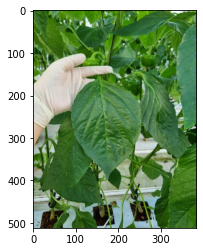

In [8]:
# image
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
# json
sample_json

{'annotations': {'area': 3,
  'bbox': [{'h': 237.8629402281746,
    'w': 165.0040302579365,
    'x': 89.14301990327381,
    'y': 162.00396825396825}],
  'crop': 3,
  'disease': 'b7',
  'grow': 13,
  'part': [{'h': 78.85906498015873,
    'id': 0,
    'w': 32.14364769345238,
    'x': 125.57248263888889,
    'y': 177.43291170634922},
   {'h': 57.858568948412696,
    'id': 1,
    'w': 35.57229662698413,
    'x': 162.8591114831349,
    'y': 187.290287078373}],
  'risk': 1},
 'description': {'date': '20211126',
  'height': 512,
  'image': '10027.jpg',
  'region': 0,
  'task': 2,
  'time': '0935',
  'width': 384}}

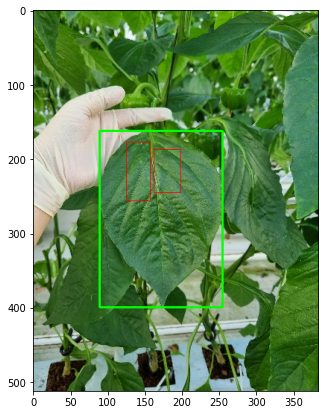

In [10]:
# visualize bbox
plt.figure(figsize=(7,7))
points = sample_json['annotations']['bbox'][0]
part_points = sample_json['annotations']['part']
img = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

cv2.rectangle(
    img,
    (int(points['x']), int(points['y'])),
    (int((points['x']+points['w'])), int((points['y']+points['h']))),
    (0, 255, 0),
    2
)
for part_point in part_points:
    point = part_point
    cv2.rectangle(
        img,
        (int(point['x']), int(point['y'])),
        (int((point['x']+point['w'])), int((point['y']+point['h']))),
        (255, 0, 0),
        1
    )
plt.imshow(img)
plt.show()

# 데이터 로드

## 환경 데이터 통계량 계산 for MinMax Scaling

In [11]:
# 분석에 사용할 feature 선택
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

csv_files = sorted(glob('/content/train/10027/10027.csv'))

#sample_csv = pd.read_csv(f'/content/train/{sample}/{sample}.csv')


temp_csv = pd.read_csv(csv_files[0])[csv_features]
max_arr, min_arr = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()

# feature 별 최대값, 최솟값 계산
for csv in tqdm(csv_files[1:]):
    temp_csv = pd.read_csv(csv)[csv_features]
    temp_max, temp_min = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
    max_arr = np.max([max_arr,temp_max], axis=0)
    min_arr = np.min([min_arr,temp_min], axis=0)

# feature 별 최대값, 최솟값 dictionary 생성
csv_feature_dict = {csv_features[i]:[min_arr[i], max_arr[i]] for i in range(len(csv_features))}
csv_feature_dict

0it [00:00, ?it/s]


{'내부 습도 1 최고': [42.4, 92.4],
 '내부 습도 1 최저': [39.6, 92.1],
 '내부 습도 1 평균': [41.3, 92.3],
 '내부 온도 1 최고': [5.0, 18.7],
 '내부 온도 1 최저': [4.9, 18.4],
 '내부 온도 1 평균': [4.9, 18.6],
 '내부 이슬점 최고': [2.6, 11.7],
 '내부 이슬점 최저': [1.7, 10.2],
 '내부 이슬점 평균': [2.4, 11.0]}

## CustomDataset 제작

In [12]:
# 변수 설명 csv 파일 참조
crop = {'1':'딸기','2':'토마토','3':'파프리카','4':'오이','5':'고추','6':'시설포도'}
disease = {'1':{'a1':'딸기잿빛곰팡이병','a2':'딸기흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '2':{'a5':'토마토흰가루병','a6':'토마토잿빛곰팡이병','b2':'열과','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '3':{'a9':'파프리카흰가루병','a10':'파프리카잘록병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '4':{'a3':'오이노균병','a4':'오이흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '5':{'a7':'고추탄저병','a8':'고추흰가루병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '6':{'a11':'시설포도탄저병','a12':'시설포도노균병','b4':'일소피해','b5':'축과병'}}
risk = {'1':'초기','2':'중기','3':'말기'}

label_description = {}
for key, value in disease.items():
    label_description[f'{key}_00_0'] = f'{crop[key]}_정상'
    for disease_code in value:
        for risk_code in risk:
            label = f'{key}_{disease_code}_{risk_code}'
            label_description[label] = f'{crop[key]}_{disease[key][disease_code]}_{risk[risk_code]}'
list(label_description.items())[:]

[('1_00_0', '딸기_정상'),
 ('1_a1_1', '딸기_딸기잿빛곰팡이병_초기'),
 ('1_a1_2', '딸기_딸기잿빛곰팡이병_중기'),
 ('1_a1_3', '딸기_딸기잿빛곰팡이병_말기'),
 ('1_a2_1', '딸기_딸기흰가루병_초기'),
 ('1_a2_2', '딸기_딸기흰가루병_중기'),
 ('1_a2_3', '딸기_딸기흰가루병_말기'),
 ('1_b1_1', '딸기_냉해피해_초기'),
 ('1_b1_2', '딸기_냉해피해_중기'),
 ('1_b1_3', '딸기_냉해피해_말기'),
 ('1_b6_1', '딸기_다량원소결핍 (N)_초기'),
 ('1_b6_2', '딸기_다량원소결핍 (N)_중기'),
 ('1_b6_3', '딸기_다량원소결핍 (N)_말기'),
 ('1_b7_1', '딸기_다량원소결핍 (P)_초기'),
 ('1_b7_2', '딸기_다량원소결핍 (P)_중기'),
 ('1_b7_3', '딸기_다량원소결핍 (P)_말기'),
 ('1_b8_1', '딸기_다량원소결핍 (K)_초기'),
 ('1_b8_2', '딸기_다량원소결핍 (K)_중기'),
 ('1_b8_3', '딸기_다량원소결핍 (K)_말기'),
 ('2_00_0', '토마토_정상'),
 ('2_a5_1', '토마토_토마토흰가루병_초기'),
 ('2_a5_2', '토마토_토마토흰가루병_중기'),
 ('2_a5_3', '토마토_토마토흰가루병_말기'),
 ('2_a6_1', '토마토_토마토잿빛곰팡이병_초기'),
 ('2_a6_2', '토마토_토마토잿빛곰팡이병_중기'),
 ('2_a6_3', '토마토_토마토잿빛곰팡이병_말기'),
 ('2_b2_1', '토마토_열과_초기'),
 ('2_b2_2', '토마토_열과_중기'),
 ('2_b2_3', '토마토_열과_말기'),
 ('2_b3_1', '토마토_칼슘결핍_초기'),
 ('2_b3_2', '토마토_칼슘결핍_중기'),
 ('2_b3_3', '토마토_칼슘결핍_말기'),
 ('2_b6_1', '토마토_다량원소결핍 (N)_초기'),
 ('2_b6_2

In [13]:
label_encoder = {key:idx for idx, key in enumerate(label_description)}
label_decoder = {val:key for key, val in label_encoder.items()}

In [14]:
class CustomDataset(Dataset):
    def __init__(self, files, labels=None, mode='train'):
        self.mode = mode
        self.files = files
        self.csv_feature_dict = csv_feature_dict
        self.csv_feature_check = [0]*len(self.files)
        self.csv_features = [None]*len(self.files)
        self.max_len = -1 * 24*6
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        file = self.files[i]
        file_name = file.split('/')[-1]
        
        json_path = f'{file}/{file_name}.json'
        image_path = f'{file}/{file_name}.jpg'
        
        if self.csv_feature_check[i] == 0:
            csv_path = f'{file}/{file_name}.csv'
            df = pd.read_csv(csv_path)

            # MinMax scaling
            for col in self.csv_feature_dict.keys():
                df[col] = df[col] - self.csv_feature_dict[col][0]
                df[col] = df[col] / (self.csv_feature_dict[col][1]-self.csv_feature_dict[col][0])
            
            # transpose to sequential data
            csv_feature = df[self.csv_feature_dict.keys()].to_numpy()[self.max_len:].T
            self.csv_features[i] = csv_feature
            self.csv_feature_check[i] = 1
        else:
            csv_feature = self.csv_features[i]
        
        img = cv2.imread(image_path)
        #print(image_path+str(img.shape))

        img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32)/255
        img = np.transpose(img, (2,0,1))
        
        #print(image_path+str(img.shape))

        if self.mode == 'train':
            with open(json_path, 'r') as f:
                json_file = json.load(f)
            
            crop = json_file['annotations']['crop']
            disease = json_file['annotations']['disease']
            risk = json_file['annotations']['risk']
            label = f'{crop}_{disease}_{risk}'
            
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32),
                'label' : torch.tensor(self.label_encoder[label], dtype=torch.long)
            }
        else:
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32)
            }

In [15]:
class CustomDataset(Dataset):
    def __init__(self, files, labels=None, mode='train'):
        self.mode = mode
        self.files = files
        self.csv_feature_dict = csv_feature_dict
        self.csv_feature_check = [0]*len(self.files)
        self.csv_features = [None]*len(self.files)
        self.max_len = 24 * 6
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        file = self.files[i]
        file_name = file.split('/')[-1]
        
        # csv
        if self.csv_feature_check[i] == 0:
            csv_path = f'{file}/{file_name}.csv'
            df = pd.read_csv(csv_path)[self.csv_feature_dict.keys()]
            df = df.replace('-', 0)
            # MinMax scaling
            for col in df.columns:
                df[col] = df[col].astype(float) - self.csv_feature_dict[col][0]
                df[col] = df[col] / (self.csv_feature_dict[col][1]-self.csv_feature_dict[col][0])
            # zero padding
            pad = np.zeros((self.max_len, len(df.columns)))
            length = min(self.max_len, len(df))
            pad[-length:] = df.to_numpy()[-length:]
            # transpose to sequential data
            csv_feature = pad.T
            self.csv_features[i] = csv_feature
            self.csv_feature_check[i] = 1
        else:
            csv_feature = self.csv_features[i]
        
        # image
        image_path = f'{file}/{file_name}.jpg'
        img = cv2.imread(image_path)
        img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32)/255
        img = np.transpose(img, (2,0,1))
        
        if self.mode == 'train':
            json_path = f'{file}/{file_name}.json'
            with open(json_path, 'r') as f:
                json_file = json.load(f)
            
            crop = json_file['annotations']['crop']
            disease = json_file['annotations']['disease']
            risk = json_file['annotations']['risk']
            label = f'{crop}_{disease}_{risk}'
            
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32),
                'label' : torch.tensor(self.label_encoder[label], dtype=torch.long)
            }
        else:
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32)
            }

# 하이퍼파라미터 및 변수

In [16]:
device = torch.device("cuda:0")
batch_size = 1
class_n = len(label_encoder)
learning_rate = 1e-4
embedding_dim = 512
num_features = len(csv_feature_dict)
max_len = 24*6
dropout_rate = 0.1
epochs = 5
vision_pretrain = True
save_path = 'best_model.pt'

# 데이터셋 구성

In [17]:
data_files = glob('/content/train/*')


train = data_files[:1440]
val = data_files[1440:2880]

In [18]:
train_dataset = CustomDataset(train)
val_dataset = CustomDataset(val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=2, shuffle=False)

# 모델

## 이미지 분류 모델 : Resnet50

In [19]:
class CNN_Encoder(nn.Module):
    def __init__(self, class_n, rate=0.1):
        super(CNN_Encoder, self).__init__()
        self.model = models.resnet50(pretrained=True)
    
    def forward(self, inputs):
        output = self.model(inputs)
        return output

## 시계열 모델 : LSTM

In [20]:
class RNN_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(RNN_Decoder, self).__init__()
        self.lstm = nn.LSTM(max_len, embedding_dim)
        self.rnn_fc = nn.Linear(num_features*embedding_dim, 1000)
        self.final_layer = nn.Linear(1000 + 1000, class_n)
        self.dropout = nn.Dropout(rate)

    def forward(self, enc_out, dec_inp):
        hidden, _ = self.lstm(dec_inp)
        hidden = hidden.view(hidden.size(0), -1)
        hidden = self.rnn_fc(hidden)
        concat = torch.cat([enc_out, hidden], dim=1) # enc_out + hidden 
        fc_input = concat
        output = self.dropout((self.final_layer(fc_input)))
        return output

## 앙상블

In [21]:
class CNN2RNN(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(CNN2RNN, self).__init__()
        self.cnn = CNN_Encoder(embedding_dim, rate)
        self.rnn = RNN_Decoder(max_len, embedding_dim, num_features, class_n, rate)
        
    def forward(self, img, seq):
        cnn_output = self.cnn(img)
        output = self.rnn(cnn_output, seq)
        
        return output

In [22]:
model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# 학습


In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [24]:
def accuracy_function(real, pred):    
    real = real.cpu()
    pred = torch.argmax(pred, dim=1).cpu()
    score = f1_score(real, pred, average='macro')
    return score

def train_step(batch_item, training):
    img = batch_item['img'].to(device)
    csv_feature = batch_item['csv_feature'].to(device)
    label = batch_item['label'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        score = accuracy_function(label, output)
        return loss, score
    else:
        model.eval()
        with torch.no_grad():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        score = accuracy_function(label, output)
        return loss, score

In [25]:
loss_plot, val_loss_plot = [], []
metric_plot, val_metric_plot = [], []

for epoch in range(epochs):
    total_loss, total_val_loss = 0, 0
    total_acc, total_val_acc = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_loss += batch_loss
        total_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Loss' : '{:06f}'.format(total_loss/(batch+1)),
            'Mean F-1' : '{:06f}'.format(total_acc/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    metric_plot.append(total_acc/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_val_loss += batch_loss
        total_val_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
            'Mean Val F-1' : '{:06f}'.format(total_val_acc/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    val_metric_plot.append(total_val_acc/(batch+1))
    
    if np.max(val_metric_plot) == val_metric_plot[-1]:
        torch.save(model, save_path)

1440it [01:38, 14.62it/s, Epoch=1, Loss=0.607910, Mean Loss=2.285410, Mean F-1=0.376389]
1440it [00:45, 31.38it/s, Epoch=1, Val Loss=0.034787, Mean Val Loss=11.979681, Mean Val F-1=0.287500]
1440it [01:39, 14.53it/s, Epoch=2, Loss=0.066711, Mean Loss=1.536922, Mean F-1=0.568750]
1440it [00:45, 31.56it/s, Epoch=2, Val Loss=0.210853, Mean Val Loss=3.408508, Mean Val F-1=0.409028]
1440it [01:39, 14.47it/s, Epoch=3, Loss=1.800781, Mean Loss=1.329146, Mean F-1=0.662500]
1440it [00:45, 31.48it/s, Epoch=3, Val Loss=0.063855, Mean Val Loss=2.274599, Mean Val F-1=0.453472]
1440it [01:38, 14.67it/s, Epoch=4, Loss=0.185547, Mean Loss=1.241607, Mean F-1=0.672917]
1440it [00:44, 32.50it/s, Epoch=4, Val Loss=3.457470, Mean Val Loss=3.277511, Mean Val F-1=0.363194]
1440it [01:38, 14.67it/s, Epoch=5, Loss=0.509766, Mean Loss=1.126500, Mean F-1=0.706250]
1440it [00:44, 32.68it/s, Epoch=5, Val Loss=0.006913, Mean Val Loss=3.482027, Mean Val F-1=0.496528]


# 학습 결과

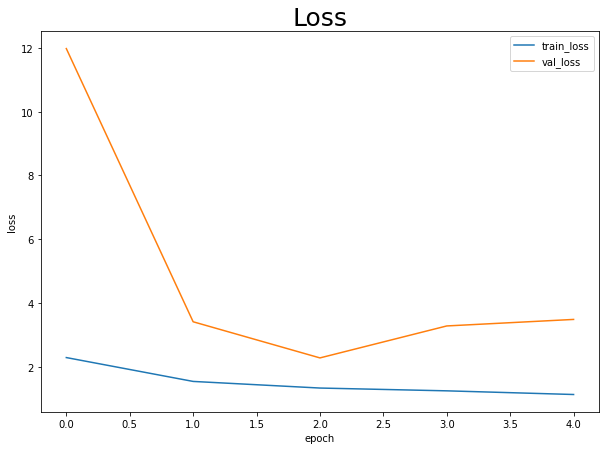

In [26]:
plt.figure(figsize=(10,7))
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss", fontsize=25)
plt.legend()
plt.show()

# 추론

In [27]:
def predict(dataset):
    model.eval()
    tqdm_dataset = tqdm(enumerate(dataset))
    training = False
    results = []
    answer = []
    for batch, batch_item in tqdm_dataset:
        img = batch_item['img'].to(device)
        seq = batch_item['csv_feature'].to(device)
        with torch.no_grad():
            output = model(img, seq)
        output = torch.tensor(torch.argmax(output, axis=-1), dtype=torch.int32).cpu().numpy()
        results.extend(output)
        answer.extend(batch_item['label'])
    return results, answer

preds, answer = predict(val_dataloader)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
1440it [00:38, 37.72it/s]


## 추론 결과 시각화

In [28]:
answer = np.array([label_description[label_decoder[int(val)]] for val in answer])
preds = np.array([label_description[label_decoder[int(val)]] for val in preds])

new_crosstab = pd.crosstab(answer, preds, rownames=['answer'], colnames=['preds'])
new_crosstab

preds,고추_고추탄저병_중기,고추_다량원소결핍 (K)_초기,고추_다량원소결핍 (N)_초기,고추_다량원소결핍 (P)_초기,고추_정상,딸기_정상,시설포도_시설포도노균병_중기,시설포도_일소피해_초기,시설포도_정상,시설포도_축과병_초기,오이_정상,토마토_정상,토마토_토마토흰가루병_중기,파프리카_다량원소결핍 (K)_초기,파프리카_다량원소결핍 (N)_초기,파프리카_다량원소결핍 (P)_초기,파프리카_정상,파프리카_칼슘결핍_초기,파프리카_파프리카흰가루병_중기,파프리카_파프리카흰가루병_초기
answer,,,,,,,,,,,,,,,,,,,,
고추_고추탄저병_중기,24,0,0,0,0,2,0,0,0,0,5,0,0,0,0,0,0,0,0,0
고추_다량원소결핍 (K)_초기,0,0,0,0,0,2,0,0,0,0,0,0,0,34,0,0,0,0,0,0
고추_다량원소결핍 (N)_초기,0,0,9,0,0,0,0,0,0,0,0,0,0,30,0,0,0,11,0,0
고추_다량원소결핍 (P)_초기,0,0,0,13,0,1,0,0,0,0,0,1,0,24,0,0,0,0,0,0
고추_정상,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
딸기_정상,0,0,2,0,0,202,0,0,1,0,0,0,0,0,0,0,5,0,0,0
시설포도_시설포도노균병_중기,0,0,0,0,0,0,1,0,7,0,0,0,0,0,0,0,0,0,0,0
시설포도_시설포도노균병_초기,0,0,0,0,0,3,0,0,2,0,1,0,0,0,0,0,0,0,0,0
시설포도_시설포도탄저병_중기,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0
